In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/simplesentiment/products_sentiment_train.tsv
/kaggle/input/simplesentiment/products_sentiment_sample_submission.csv
/kaggle/input/simplesentiment/products_sentiment_test.tsv


In [74]:
train = pd.read_csv('/kaggle/input/simplesentiment/products_sentiment_train.tsv', sep='\t', names=['data','labels'])
test = pd.read_csv('/kaggle/input/simplesentiment/products_sentiment_test.tsv', sep='\t')
sample = pd.read_csv('/kaggle/input/simplesentiment/products_sentiment_sample_submission.csv')

In [75]:
train

,data,labels
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1
...,...,...
1995,"speaker phone quality is good , and poping in ...",1
1996,"the "" movies "" last about 5 seconds .",0
1997,overall i like it .,1
1998,i began taking pics as soon as i got this came...,1


In [76]:
train.shape

(2000, 2)

In [77]:
test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [78]:
test.shape

(500, 2)

In [79]:
sample.head()

,Id,y
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [80]:
X = train['data']
y = train['labels']

In [81]:
def handle_negations(text):    
    return text.replace("n't", "not").replace("n 't", " not").replace("dont", "do not")

X = X.apply(handle_negations)

In [82]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [83]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF, TruncatedSVD
import nltk

In [84]:
for vect in [CountVectorizer,TfidfVectorizer]:
    for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
        for transformer in [TruncatedSVD, TfidfTransformer]: 
            print(str(vect) +" - "+str(clf) + " - "+str(transformer))
            print(cross_val_score(text_classifier(vect(), transformer(), clf(max_iter=1000)), X, y, n_jobs=8).mean())
            print("\n")

<class 'sklearn.feature_extraction.text.CountVectorizer'> - <class 'sklearn.linear_model._logistic.LogisticRegression'> - <class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>
0.6369999999999999


<class 'sklearn.feature_extraction.text.CountVectorizer'> - <class 'sklearn.linear_model._logistic.LogisticRegression'> - <class 'sklearn.feature_extraction.text.TfidfTransformer'>
0.7695


<class 'sklearn.feature_extraction.text.CountVectorizer'> - <class 'sklearn.svm._classes.LinearSVC'> - <class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>
0.6369999999999999


<class 'sklearn.feature_extraction.text.CountVectorizer'> - <class 'sklearn.svm._classes.LinearSVC'> - <class 'sklearn.feature_extraction.text.TfidfTransformer'>
0.7705


<class 'sklearn.feature_extraction.text.CountVectorizer'> - <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> - <class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>
0.6289999999999999


<class 'sklearn.feature_extraction.text.Cou

In [85]:
clf_pipeline = Pipeline(
            [("vectorizer", CountVectorizer( ngram_range=(1,5),max_df=0.75 )), 
            ("transformer", TfidfTransformer(smooth_idf=True,use_idf=True)),
            ("classifier", LinearSVC(penalty='l1', C=0.55, fit_intercept=False, dual=False,  max_iter=100000))]
        )

print(cross_val_score(clf_pipeline, X, y, n_jobs=4, cv=7).mean())

0.7305133463028198


In [86]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)
X = train['data'].values.reshape(-1, 1)
X_over, y_over = over_sampler.fit_resample(X,y)

print(cross_val_score(clf_pipeline,X_over.reshape(1,X_over.shape[0])[0],y_over,cv=7).mean())

0.7507849293563579


In [87]:
# расчет метрик
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_over.reshape(1,X_over.shape[0])[0], y_over, test_size=0.25, random_state=0)
clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       330
           1       0.71      0.75      0.73       307

    accuracy                           0.73       637
   macro avg       0.73      0.73      0.73       637
weighted avg       0.73      0.73      0.73       637



In [88]:
clf_pipeline.fit(X_over.reshape(1,X_over.shape[0])[0], y_over)
test['y'] = clf_pipeline.predict(test.text)

# сохранить решение
test.head()
test[['Id','y']].to_csv('sample_sabmission.csv', index = False)

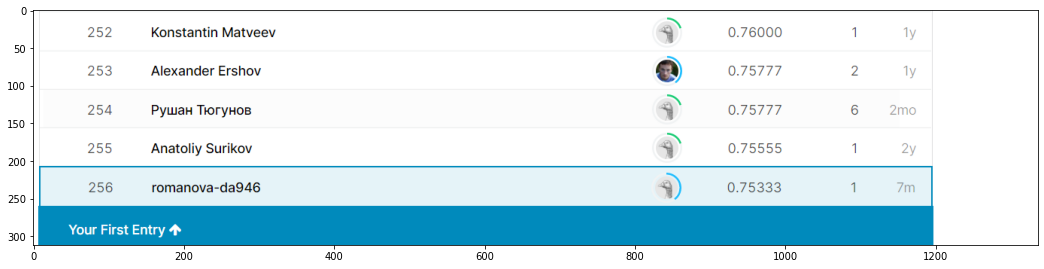

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(18,10))
image = mpimg.imread("screeshot.bmp")
plt.imshow(image)
plt.show()